# Libraries

In [46]:
!pip install gpboost -U
!pip install merf
!pip install -q statsmodels

In [47]:
import gpboost as gpb
import numpy as np
import scipy
import time
import copy
import pandas as pd
import matplotlib.pyplot as plt
from merf import MERF
from sklearn.datasets import make_friedman3
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, cross_val_score
from tqdm.notebook import tqdm, tnrange
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Helper functions

In [48]:
def linear_func(n_samples, random_state=1):
    np.random.seed(random_state)
    X = np.random.uniform(size=(n_samples, 4))
    F = 1 + np.sum(X, axis=1)

    return X, F

In [49]:
def exponential_kernel(x1, x2, sigma2, rho):
    '''
    Computes the exponential kernel matrix between two vectors.
    '''
    x1 = np.expand_dims(x1, axis=1)
    x2 = np.expand_dims(x2, axis=1)

    return sigma2 * np.exp(-scipy.spatial.distance.cdist(x1, x2, 'sqeuclidean') / rho)

In [50]:
def generate_data(n, m, p, func, shared_gp=True, random_state=1):
    # Features
    if func == 'make_friedman3':
        X, F = make_friedman3(n_samples=n, random_state=random_state)
        F *= 10**0.5
    elif func == 'linear_func':
        X, F = linear_func(n_samples=n, random_state=random_state)
    else:
        raise Exception('function is invalid') 

    # Create groups
    group = np.arange(n) # Variable that stores group IDs
    for i in range(m):
        group[i*p:(i+1)*p] = i

    # Incidence matrix relating grouped random effects to observations
    Z1 = np.zeros((n, m))
    for i in range(m):
        Z1[np.where(group==i), i] = 1

    # Simulate random (sorted) observation times for each group
    rng = np.random.default_rng(seed=random_state)
    times_arrays = [np.sort(rng.choice(1000, size=p, replace=False, shuffle=False)) for i in range(m)]
    times = np.concatenate(times_arrays)

    # Simulate GPs
    GP_list = []
    np.random.seed(random_state)
    if shared_gp:
        # Simulate GPs with same parameters
        sigma2_2 = 1 ** 2  # Marginal variance of GP
        rho = 0.1  # GP Range parameter
        for arr in times_arrays:
            K = exponential_kernel(arr, arr, sigma2_2, rho)
            g = np.random.multivariate_normal(mean=np.zeros(p), cov=K)
            GP_list.append(g)
    else:
        # Simulate GPs with different, random parameters
        for arr in times_arrays:
            sigma2_2 = scipy.stats.invgamma.rvs(1, loc=0, scale=10)
            rho = np.random.uniform(0.01, 1000)
            K = exponential_kernel(arr, arr, sigma2_2, rho)
            g = np.random.multivariate_normal(mean=np.zeros(p), cov=K)
            GP_list.append(g)

    # Simulate outcome variable
    np.random.seed(random_state)
    sigma2 = 0.5 ** 2  # Error variance
    b = np.random.normal(size=m) # Simulate random effect intercept
    G = np.dot(Z1, b) + np.concatenate(GP_list) # Combine random effect intercept with GP
    epsilon = np.sqrt(sigma2) * np.random.normal(size=n) # Simulate error term
    y = F + G + epsilon

    # Create dataframes
    X = pd.concat([pd.DataFrame(group, columns=['group']), pd.DataFrame(times, columns=['times']), pd.DataFrame(X,columns=['feature_1','feature_2','feature_3','feature_4'])], axis=1)
    data = pd.concat([X, pd.DataFrame(y, columns=['y'])], axis=1)

    return data, X, y, F

In [51]:
def generate_datasets(n, m, p, n_datasets, n_valid, func, shared_gp=True, random_state=1):
    datasets = {}
    datasets['data'] = []
    datasets['X_train'] = []
    datasets['X_test1'] = []
    datasets['X_test2'] = []
    datasets['y_train'] = []
    datasets['y_test1'] = []
    datasets['y_test2'] = []
    datasets['data_train'] = []
    datasets['F_test1'] = []
    datasets['F_test2'] = []

    # Create training and test sets
    for i in range(n_datasets):
        data, X, y, F = generate_data(n, m, p, func, shared_gp, random_state=i+random_state)
        datasets['data'].append(data)

        # Extrapolation test set
        group_sizes = data.groupby(['group']).size().to_numpy()
        X_new, X_test1, y_new, y_test1, F_new, F_test1 = train_test_split_grouped_extrapolation(X, y, F, X['group'], test_size=0.2, random_state=i)

        # Interpolation test set
        group_sizes = X_new.groupby(['group']).size().to_numpy()
        X_train, X_test2, y_train, y_test2, _, F_test2 = train_test_split_grouped_interpolation(X_new, y_new, F_new, group_sizes, test_size=0.25, random_state=i)

        # Create dataset object
        data_train = gpb.Dataset(data=X_train[['feature_1','feature_2','feature_3','feature_4']], label=y_train)
        datasets['X_train'].append(X_train)
        datasets['X_test1'].append(X_test1)
        datasets['X_test2'].append(X_test2)
        datasets['y_train'].append(y_train)
        datasets['y_test1'].append(y_test1)
        datasets['y_test2'].append(y_test2)
        datasets['F_test1'].append(F_test1)
        datasets['F_test2'].append(F_test2)
        datasets['data_train'].append(data_train)
    
    # Create validation datasets
    validation_datasets = {}
    validation_datasets['X'] = []
    validation_datasets['y'] = []
    validation_datasets['data_train'] = []
    for i in range(n_valid):
        data, X, y, _ = generate_data(n, m, p, func, shared_gp, random_state=i+n_datasets+random_state)
        X['times'] = pd.Series(np.tile(np.arange(p)*10+10, m)) # Fix times across validation datasets for grid search
        data_train = gpb.Dataset(data=X[['feature_1','feature_2','feature_3','feature_4']], label=y)
        validation_datasets['X'].append(X)
        validation_datasets['y'].append(y)
        validation_datasets['data_train'].append(data_train)

    return datasets, validation_datasets

In [52]:
# Create a function to do Group K-fold CV with MERF
def MERF_cv(X, Z, group_data, y, random_state=1):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(Z, pd.DataFrame):
        Z = Z.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    if isinstance(group_data, pd.Series):
        group_data = group_data.to_numpy()
        
    n_estimators_list = [100, 200, 300]
    accuracies = []
    for n_estimators in tqdm(n_estimators_list):
        fixed_effects_model= RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=random_state)
        group_kfold = GroupKFold(n_splits=5)
        model_accuracies = []
        for train_index, test_index in group_kfold.split(X, y, group_data):
            X_train, X_test = X[train_index], X[test_index]
            Z_train, Z_test = Z[train_index], Z[test_index]
            y_train, y_test = y[train_index], y[test_index]
            group_train, group_test = group_data[train_index], group_data[test_index]
            merf_model = MERF(fixed_effects_model, max_iterations=100)
            merf_model.fit(X_train, Z_train, pd.Series(group_train), y_train)
            y_pred = merf_model.predict(X_test, Z_test, pd.Series(group_test))
            model_accuracies.append(np.sqrt(np.mean((y_test-y_pred)**2)))
        accuracies.append(np.mean(model_accuracies))

    return np.array(accuracies)

In [53]:
# Create a function to do Group K-fold CV with MERF across datasets
def MERF_cv_multiple(validation_datasets, n_valid):
    accuracies = np.zeros((n_valid, 3))
    for i in tnrange(n_valid):
        X = validation_datasets['X'][i]
        y = validation_datasets['y'][i]
        Z = np.column_stack((np.ones(len(X)), X['times']))
        accuracies[i] = MERF_cv(X[['feature_1','feature_2','feature_3','feature_4']], Z, groups, y)
    
    return np.sum(accuracies, axis=0)

In [54]:
def cv_multiple(algorithm, params):
    results_arr = np.zeros((n_valid, len(params)))
    for n in tnrange(len(params)):
        for i in range(n_valid):
            X = validation_datasets['X'][i]
            y = validation_datasets['y'][i]
            if algorithm == 'Ridge':
                model = Ridge(alpha=params[n], random_state=1)
            elif algorithm == 'Random Forest':
                model = RandomForestRegressor(n_estimators=params[n], random_state=1, n_jobs=-1)
            elif algorithm == 'LGBM':
                model = LGBMRegressor(n_estimators=params[n], random_state=1, n_jobs=-1)
            else:
                raise Exception('Algorithm is invalid') 
            scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
            results_arr[i, n] = np.mean(scores)
    results_arr_mean = np.mean(results_arr, axis=0)
    best_index = np.argmax(results_arr_mean)
    best_param = params[best_index]
    print('Best param: ', best_param)

In [55]:
def train_test_split_grouped(X, y, F, group_sizes, test_size=0.2, random_state=1):
    '''
    Train/test dataset split. The test set may contain observations from groups also seen in the training set, or from entirely new groups not seen during training.
    Since we are dealing with temporal data, the test set only contains future observations from groups in the training set if the same group appears in both the training and test sets.
    '''
    assert len(X) == len(y), "lengths of input data array X and labels array y must be the same"
    assert len(y) == len(F), "lengths of F and y must be the same"
    assert 0 < test_size < 1, "Test size must be strictly between 0 and 1"
    assert np.sum(group_sizes) == len(y), "Sum of group_sizes must be equal to length of labels array y"
    assert group_sizes.all() > 0, "Group sizes should be non-negative"

    np.random.seed(random_state)
    y_len = len(y)
    test_len = int(test_size * y_len)
    sample_len = 0
    no_groups = len(group_sizes)
    test_idx = []
    n_samples_chosen_per_group = np.zeros_like(group_sizes)
    last_idx_arr = np.cumsum(group_sizes)-1 # Array of index of the last observation in each group within the overall dataset

    # Keep picking observations until the required number of test observations has been picked
    while sample_len < test_len:
        group_idx = np.random.randint(no_groups) # Pick a random group
        if group_sizes[group_idx] > 0:
            n = np.random.randint(min([group_sizes[group_idx], test_len-sample_len])) + 1 # Pick a random sample of size n>=1 from the chosen group
            last_idx = last_idx_arr[group_idx]-n_samples_chosen_per_group[group_idx] # Index of the last observation remaining in each group within the overall dataset
            test_idx += [last_idx-i for i in range(n)]
            n_samples_chosen_per_group[group_idx] += n # Update number of samples chosen from the group
            group_sizes[group_idx] -= n # Update current group sizes
            sample_len += n

    mask = np.ones(y_len, dtype=bool)
    mask[test_idx] = False
    X_train, X_test = X[mask], X[~mask]
    y_train, y_test = y[mask], y[~mask]
    F_train, F_test = F[mask], F[~mask]

    return X_train, X_test, y_train, y_test, F_train, F_test

In [56]:
def train_test_split_grouped_interpolation(X, y, F, group_sizes, test_size=0.2, random_state=1):
    '''
    Train/test split, but test set contains at least one observation from each group in the training set, and contains no unseen groups.
    '''
    assert len(X) == len(y), "lengths of input data array X and labels array y must be the same"
    assert len(y) == len(F), "lengths of F and y must be the same"
    assert 0 < test_size < 1, "Test size must be strictly between 0 and 1"
    assert np.sum(group_sizes) == len(y), "Sum of group_sizes must be equal to length of labels array y"
    assert group_sizes.all() > 0, "Group sizes should be non-negative"
    assert len(group_sizes) < len(X), "Number of groups should be less than number of observations"

    np.random.seed(random_state)
    y_len = len(y)
    test_len = int(test_size * y_len)
    no_groups = len(group_sizes)

    # Pick one observation from all groups
    sample_len = no_groups
    n_samples_chosen_per_group = np.ones_like(group_sizes)
    last_idx_arr = np.cumsum(group_sizes)-1 # Array of index of the last observation in each group within the overall dataset
    test_idx = [last_idx_arr[i] for i in range(no_groups)]
    group_sizes_new = group_sizes.copy()
    group_sizes_new -= 1

    # Keep picking more observations until the required number of test observations has been picked
    while sample_len < test_len:
        group_idx = np.random.randint(no_groups) # Pick a random group
        if group_sizes_new[group_idx] > 1:
            if test_len - sample_len > 1:
                n = np.random.randint(1, min([group_sizes_new[group_idx], test_len-sample_len])) # Pick a random sample of size 1<=n<group_size from the chosen group
            else:
                n = 1
            last_idx = last_idx_arr[group_idx]-n_samples_chosen_per_group[group_idx] # Index of the last observation remaining in each group within the overall dataset
            test_idx += [last_idx-i for i in range(n)]
            n_samples_chosen_per_group[group_idx] += n # Update number of samples chosen from the group
            group_sizes_new[group_idx] -= n # Update current group sizes
            sample_len += n

    mask = np.ones(y_len, dtype=bool)
    mask[test_idx] = False
    X_train, X_test = X[mask], X[~mask]
    y_train, y_test = y[mask], y[~mask]
    F_train, F_test = F[mask], F[~mask]

    return X_train, X_test, y_train, y_test, F_train, F_test

In [57]:
def train_test_split_grouped_extrapolation(X, y, F, groups, test_size=0.2, random_state=1):
    '''
    Train/test split, but test set only contains only unseen groups.
    Note: X should be a dataframe of observations.
    ``test_size`` represents the proportion of groups to include in the test split (rounded up).
    '''
    train_idx, test_idx = next(GroupShuffleSplit(test_size=test_size, random_state=random_state).split(X, y, groups))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    F_train, F_test = F[train_idx], F[test_idx]

    return X_train, X_test, y_train, y_test, F_train, F_test

In [58]:
def grid_search_tune_parameters_multiple(param_grid, train_sets, params=None, num_try_random=None,
                                         num_boost_round=100, gp_model=None,
                                         use_gp_model_for_validation=True, train_gp_model_cov_pars=True,
                                         folds=None, nfold=5, stratified=False, shuffle=True,
                                         metrics=None, fobj=None, feval=None, init_model=None,
                                         feature_name='auto', categorical_feature='auto',
                                         early_stopping_rounds=None, fpreproc=None,
                                         verbose_eval=1, seed=0, callbacks=None):
    '''
    Conducts grid search over a list of training sets.
    '''
    # Check correct format
    if not isinstance(param_grid, dict):
        raise ValueError('param_grid needs to be a dict')
    if verbose_eval is None:
        verbose_eval = 0
    else:
        if not isinstance(verbose_eval, int):
            raise ValueError('verbose_eval needs to be int')
    if params is None:
        params = {}
    else:
        params = copy.deepcopy(params)
    param_grid = copy.deepcopy(param_grid)
    for param in param_grid:
        if gpb.basic.is_numeric(param_grid[param]):
            param_grid[param] = [param_grid[param]]
        param_grid[param] = gpb.basic._format_check_1D_data(param_grid[param],
                                                  data_name=param, check_data_type=False,
                                                  check_must_be_int=False, convert_to_type=None)

    # Determine combinations of parameter values that should be tried out
    grid_size = gpb.engine._get_grid_size(param_grid)
    if num_try_random is not None:
        if num_try_random > grid_size:
            raise ValueError('num_try_random is larger than the number of all possible combinations of parameters in param_grid')
        try_param_combs = np.random.RandomState(seed).choice(a=grid_size, size=num_try_random, replace=False)
        print('Starting random grid search with ' + str(num_try_random) + ' trials out of ' + str(grid_size) + ' parameter combinations...')
    else:
        try_param_combs = range(grid_size)
        print('Starting deterministic grid search with ' + str(grid_size) + ' parameter combinations...')
    if verbose_eval < 2:
        verbose_eval_cv = False
    else:
        verbose_eval_cv = True

    best_score = 1e99
    current_score = 1e99
    best_params = {}
    best_num_boost_round = num_boost_round
    counter_num_comb = 1
    for param_comb_number in try_param_combs:
        cvbst_list = []
        param_comb = gpb.engine._get_param_combination(param_comb_number=param_comb_number, param_grid=param_grid)
        for param in param_comb:
            params[param] = param_comb[param]
        if verbose_eval >= 1:
            print('Trying parameter combination ' + str(counter_num_comb) +
                  ' of ' + str(len(try_param_combs)) + ': ' + str(param_comb) + ' ...')
        for train_set in train_sets:
            cvbst = gpb.cv(params=params, train_set=train_set, num_boost_round=num_boost_round,
                        gp_model=gp_model, use_gp_model_for_validation=use_gp_model_for_validation,
                        train_gp_model_cov_pars=train_gp_model_cov_pars,
                        folds=folds, nfold=nfold, stratified=stratified, shuffle=shuffle,
                        metrics=metrics, fobj=fobj, feval=feval, init_model=init_model,
                        feature_name=feature_name, categorical_feature=categorical_feature,
                        early_stopping_rounds=early_stopping_rounds, fpreproc=fpreproc,
                        verbose_eval=verbose_eval_cv, seed=seed, callbacks=callbacks,
                        eval_train_metric=False, return_cvbooster=False)
            cvbst_list.append(cvbst)
        current_score_is_better = False
        current_score = np.mean([np.min(cvbst[next(iter(cvbst))]) for cvbst in cvbst_list])
        if current_score < best_score:
            current_score_is_better = True
        if current_score_is_better:
            best_score = current_score
            best_params = param_comb
            best_num_boost_round = np.mean([np.argmin(cvbst[next(iter(cvbst))]) for cvbst in cvbst_list])
            if verbose_eval >= 1:
                print('***** New best score (' + str(best_score) + ') found for the following parameter combination:')
                best_params_print = copy.deepcopy(best_params)
                best_params_print['num_boost_round'] = best_num_boost_round
                print(best_params_print)
        counter_num_comb = counter_num_comb + 1

    return {'best_params': best_params, 'best_iter': best_num_boost_round, 'best_score': best_score}

In [59]:
def train_and_test(datasets, n_datasets, num_boost_round=0, params={}, merf=False, linear=False, GP=False, shared=False, no_features=False):
    np.random.seed(1)
    RMSE_list1 = []
    RMSE_list2 = []
    F_list = []
    time_list = []
    for i in tnrange(n_datasets):
        data_train = datasets['data_train'][i]
        X_train = datasets['X_train'][i]
        X_test1 = datasets['X_test1'][i]
        X_test2 = datasets['X_test2'][i]
        y_train = datasets['y_train'][i]
        y_test1 = datasets['y_test1'][i]
        y_test2 = datasets['y_test2'][i]
        F_test1 = datasets['F_test1'][i]
        F_test2 = datasets['F_test2'][i]
        groups_train = X_train['group']
        groups_test1 = X_test1['group']
        groups_test2 = X_test2['group']
        times_train = X_train['times']
        times_test1 = X_test1['times']
        times_test2 = X_test2['times']
        if linear:
            if no_features:
                X_train_linear = np.ones(len(X_train))
                X_test1_linear = np.ones(len(X_test1))
                X_test2_linear = np.ones(len(X_test2))
            else:
                X_train_linear = np.column_stack((np.ones(len(X_train)), X_train[['feature_1','feature_2','feature_3','feature_4']]))
                X_test1_linear = np.column_stack((np.ones(len(X_test1)), X_test1[['feature_1','feature_2','feature_3','feature_4']]))
                X_test2_linear = np.column_stack((np.ones(len(X_test2)), X_test2[['feature_1','feature_2','feature_3','feature_4']]))

        # Define the model
        if merf:
            Z_train = np.column_stack((np.ones(len(X_train)), times_train))
            Z_test1 = np.column_stack((np.ones(len(X_test1)), times_test1))
            Z_test2 = np.column_stack((np.ones(len(X_test2)), times_test2))
            fixed_effects_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=1)
            merf_model = MERF(fixed_effects_model, max_iterations=100)
        else:
            if GP:
                if shared:
                    gp_model = gpb.GPModel(group_data=groups_train, gp_coords=times_train)
                else:
                    gp_model = gpb.GPModel(group_data=groups_train, gp_coords=times_train, cluster_ids=groups_train, cov_function='exponential')
            else:
                gp_model = gpb.GPModel(group_data=np.column_stack((groups_train, times_train)))
            gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

        # Training
        start_time = time.time()
        try:
            if merf:
                merf_model.fit(X_train[['feature_1','feature_2','feature_3','feature_4']], Z_train, groups_train, y_train)
            else:
                if linear:
                    gp_model.fit(y=y_train, X=X_train_linear)
                else:
                    bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round=num_boost_round)
            time_list.append(time.time() - start_time)

            # Prediction
            if merf:
                y_pred1 = merf_model.predict(X_test1[['feature_1','feature_2','feature_3','feature_4']], Z_test1, groups_test1)
                y_pred2 = merf_model.predict(X_test2[['feature_1','feature_2','feature_3','feature_4']], Z_test2, groups_test2)
                F_pred1 = merf_model.trained_fe_model.predict(X_test1[['feature_1','feature_2','feature_3','feature_4']])
                F_pred2 = merf_model.trained_fe_model.predict(X_test2[['feature_1','feature_2','feature_3','feature_4']])
            else:
                if linear:
                    if GP:
                        if shared:
                            y_pred1 = gp_model.predict(group_data_pred=groups_test1, gp_coords_pred=times_test1, X_pred=X_test1_linear)['mu']
                            y_pred2 = gp_model.predict(group_data_pred=groups_test2, gp_coords_pred=times_test2, X_pred=X_test2_linear)['mu']
                        else:
                            y_pred1 = gp_model.predict(group_data_pred=groups_test1, gp_coords_pred=times_test1, cluster_ids_pred=groups_test1, X_pred=X_test1_linear)['mu']
                            y_pred2 = gp_model.predict(group_data_pred=groups_test2, gp_coords_pred=times_test2, cluster_ids_pred=groups_test2, X_pred=X_test2_linear)['mu']
                    else:
                        y_pred1 = gp_model.predict(group_data_pred=np.column_stack((groups_test1, times_test1)), X_pred=X_test1_linear)['mu']
                        y_pred2 = gp_model.predict(group_data_pred=np.column_stack((groups_test2, times_test2)), X_pred=X_test2_linear)['mu']
                    if not no_features:
                        F_pred1 = X_test1_linear.dot(gp_model.get_coef())
                        F_pred2 = X_test2_linear.dot(gp_model.get_coef())
                else:
                    if GP:
                        if shared:
                            pred1 = bst.predict(data=X_test1[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=groups_test1, gp_coords_pred=times_test1)
                            pred2 = bst.predict(data=X_test2[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=groups_test2, gp_coords_pred=times_test2)
                        else:
                            pred1 = bst.predict(data=X_test1[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=groups_test1, gp_coords_pred=times_test1, cluster_ids_pred=groups_test1)
                            pred2 = bst.predict(data=X_test2[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=groups_test2, gp_coords_pred=times_test2, cluster_ids_pred=groups_test2)
                    else:
                        pred1 = bst.predict(data=X_test1[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=np.column_stack((groups_test1, times_test1)))
                        pred2 = bst.predict(data=X_test2[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=np.column_stack((groups_test2, times_test2)))
                    y_pred1 = pred1['fixed_effect'] + pred1['random_effect_mean']
                    y_pred2 = pred2['fixed_effect'] + pred2['random_effect_mean']
                    if not no_features:
                        F_pred1, F_pred2 = pred1['fixed_effect'], pred2['fixed_effect']
            
            RMSE_list1.append(np.sqrt(np.mean((y_test1-y_pred1)**2)))
            RMSE_list2.append(np.sqrt(np.mean((y_test2-y_pred2)**2)))
            if not no_features:
                F_list.append(np.sqrt(np.mean((F_test1-F_pred1)**2)))
                F_list.append(np.sqrt(np.mean((F_test2-F_pred2)**2))) # RMSE for F is given by both interpolation and extrapolation
        except:
            continue  
    if no_features:
        return time_list, RMSE_list1, RMSE_list2
    else:
        return time_list, RMSE_list1, RMSE_list2, F_list

# Experiment 0: Testing

## Create data

In [ ]:
n, m = 1000, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
data, X, y, F = generate_data(n, m, p, func='make_friedman3', shared_gp=True)
data

,group,times,feature_1,feature_2,feature_3,feature_4,y
0,0,27,41.702200,1302.406097,0.000114,4.023326,0.161366
1,0,34,14.675589,276.510637,0.186260,4.455607,4.925929
2,0,85,39.676747,1005.889907,0.419195,7.852195,5.195525
3,0,142,20.445225,1560.181095,0.027388,7.704675,3.932726
4,0,246,41.730480,1038.355154,0.140387,2.981015,6.470903
...,...,...,...,...,...,...,...
995,49,868,80.014431,1614.402714,0.513149,5.294220,4.390286
996,49,922,9.159480,572.750662,0.886648,3.459443,3.543478
997,49,968,62.118939,934.321737,0.094373,9.993685,4.161642
998,49,982,6.777083,1237.678207,0.971998,8.093738,6.717786


In [ ]:
data.describe()

,group,times,feature_1,feature_2,feature_3,feature_4,y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,24.500000,503.332000,48.924209,938.650971,0.503544,6.150520,4.213926
std,14.438091,289.448815,28.592213,471.327827,0.290179,2.877177,1.767855
min,0.000000,2.000000,0.103293,126.948623,0.000114,1.000970,-2.206568
25%,12.000000,261.000000,25.362684,528.961274,0.238749,3.704661,3.214356
50%,24.500000,491.000000,48.975230,940.389885,0.518332,6.283003,4.290655
75%,37.000000,756.000000,72.314983,1357.330419,0.751970,8.592909,5.372431
max,49.000000,999.000000,99.859909,1759.088969,0.998521,10.967534,8.803852


In [ ]:
# Split training and test sets
group_sizes = data.groupby(['group']).size().to_numpy()
X_train, X_test, y_train, y_test, F_train, F_test = train_test_split_grouped_extrapolation(X, y, F, X['group'], test_size=0.2, random_state=1)

data_train = gpb.Dataset(data=X_train[['feature_1','feature_2','feature_3','feature_4']], label=y_train)

In [ ]:
# Unique groups in training set
print('Number of unique groups in training set: ', len(X_train['group'].unique()))
X_train['group'].unique()

Number of unique groups in training set:  40


array([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 36, 37, 39, 41,
       42, 43, 44, 45, 47, 49])

## Hyperparameter tuning for GPBoost

### Random Intercept

In [ ]:
# Random Intercept
gp_model = gpb.GPModel(group_data=X_train['group'])
gp_model.set_optim_params(params={"optimizer_cov": "gradient_descent"})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.1, 0.5], 
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2', 'verbose': 0, 'num_leaves': 2**10}
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid,
                                             params=params,
                                             nfold=5,
                                             gp_model=gp_model,
                                             use_gp_model_for_validation=True,
                                             train_set=data_train,
                                             verbose_eval=0,
                                             num_boost_round=1000, 
                                             early_stopping_rounds=10,
                                             shuffle=False,
                                             seed=1,
                                             metrics='rmse')
print("Best number of iterations: ", opt_params['best_iter'])
print("Best score: ", opt_params['best_score'])
print("Best parameters: ", opt_params['best_params'])

Starting deterministic grid search with 18 parameter combinations...
Best number of iterations:  28
Best score:  1.4945814835141826
Best parameters:  {'learning_rate': 0.5, 'max_depth': 1, 'min_data_in_leaf': 10}


In [ ]:
np.random.seed(1)
gp_model = gpb.GPModel(group_data=X_train['group'])
gp_model.set_optim_params(params={"optimizer_cov": "gradient_descent"})
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 1,
          'min_data_in_leaf': 10,
          'verbose': 0}

bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model,
                num_boost_round=28)

gp_model.summary()

Covariance parameters 
['Error_term', 'group']
[1.28172126 0.74427406]


In [ ]:
pred = bst.predict(data=X_test[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=X_test['group'])
# Predicted fixed effect from tree ensemble
print(pred['fixed_effect'])
# Predicted (posterior) mean of GP
print(pred['random_effect_mean'])
# Predicted (posterior) covariance matrix of GP
print(pred)

[1.78320618 3.89658481 4.24583176 2.99310761 3.6717395  4.48412002
 1.24470784 4.24583176 5.23879922 1.0205882  4.91660836 4.03339539
 5.07124233 5.23879922 4.56016733 5.02442296 4.36869844 1.26397607
 3.85491308 2.45150407 4.64686034 1.57470182 4.53625533 5.22933888
 3.39901023 4.36869844 1.97255614 3.93655332 1.47235552 3.60124973
 5.16144667 4.34669339 4.48412002 3.88460287 2.56987037 4.48412002
 4.68853207 4.94175448 4.78609741 3.81657884 4.8739713  4.53625533
 0.76480324 1.22219443 4.58354774 4.68853207 3.38836454 3.47505754
 4.53625533 3.90943432 4.53625533 3.96046478 4.44685196 4.31656314
 4.40325614 4.76457938 1.19257253 4.47415581 4.45539145 4.38864816
 4.48412002 4.43487002 4.40325614 3.98126008 4.64924628 4.25707567
 4.53625533 1.90799783 4.59702249 4.53625533 1.19257253 4.3981085
 4.06699643 3.60414351 3.5261711  4.76457938 5.49148077 4.33252477
 3.34995211 4.48412002 4.93624633 3.89456708 4.48412002 4.8710231
 3.47642297 1.76904915 2.48606177 5.10931136 4.80391931 3.684267

### Shared GP

In [ ]:
# Shared GP
gp_model = gpb.GPModel(group_data=X_train['group'], gp_coords=X_train['times'], cov_function="exponential")
gp_model.set_optim_params(params={"optimizer_cov": "gradient_descent", "use_nesterov_acc": True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.1, 0.5], 
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2', 'verbose': 0, 'num_leaves': 2**10}
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid,
                                             params=params,
                                             nfold=5,
                                             gp_model=gp_model,
                                             use_gp_model_for_validation=True,
                                             train_set=data_train,
                                             verbose_eval=1,
                                             num_boost_round=1000, 
                                             early_stopping_rounds=10,
                                             shuffle=False,
                                             seed=1,
                                             metrics='rmse')
print("Best number of iterations: ", opt_params['best_iter'])
print("Best score: ", opt_params['best_score'])
print("Best parameters: ", opt_params['best_params'])

### Independent GP

In [ ]:
# Independent GP
gp_model = gpb.GPModel(group_data=X_train['group'], gp_coords=X_train['times'], cluster_ids=X_train['group'], cov_function="exponential")
gp_model.set_optim_params(params={"optimizer_cov": "gradient_descent", "use_nesterov_acc": True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.1, 0.5],
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2', 'verbose': 0, 'num_leaves': 2**10}
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid,
                                             params=params,
                                             nfold=5,
                                             gp_model=gp_model,
                                             use_gp_model_for_validation=True,
                                             train_set=data_train,
                                             verbose_eval=1,
                                             num_boost_round=1000, 
                                             early_stopping_rounds=10,
                                             shuffle=False,
                                             seed=1,
                                             metrics='rmse')
print("Best number of iterations: ", opt_params['best_iter'])
print("Best score: ", opt_params['best_score'])
print("Best parameters: ", opt_params['best_params'])

## Hyperparameter tuning for MERF

In [ ]:
Z = np.column_stack((np.ones(len(X_train)), X_train['times']))
accuracies = MERF_cv(X_train[['feature_1','feature_2','feature_3','feature_4']], Z, X_train['group'], y_train)

In [ ]:
print(np.argmax(accuracies))

1


## Hyperparameter tuning for group as categorical variable

In [ ]:
alpha_list = [0.01, 0.1, 1, 10, 100]
lr_accuracies = []

for n in tqdm(alpha_list):
    model = Ridge(alpha=n, random_state=1)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    lr_accuracies.append(np.mean(scores))
lr_best_index = np.argmax(lr_accuracies)
lr_best_n = alpha_list[lr_best_index]
print('Best alpha: ', lr_best_n)


Best alpha:  1
Best cross-validation accuracy: -1.5791
Standard deviation: 0.1221


In [ ]:
rf_n_estimators_list= [100, 250, 750, 1000]
rf_accuracies = []

for n in tqdm(rf_n_estimators_list):
    model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    rf_accuracies.append(np.mean(scores))
rf_best_index = np.argmax(rf_accuracies)
rf_best_n = rf_n_estimators_list[rf_best_index]
rf_best_accuracy = rf_accuracies[rf_best_index]
print('Best n_estimators: ', rf_best_n)


Best n_estimators:  750
Best cross-validation accuracy: -1.4990
Standard deviation: 0.1182


In [ ]:
lgbm_n_estimators_list= [50, 100, 200, 300]
lgbm_accuracies = []

for n in tqdm(lgbm_n_estimators_list):
    model = LGBMRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    lgbm_accuracies.append(np.mean(scores))
lgbm_best_index = np.argmax(lgbm_accuracies)
lgbm_best_n = lgbm_n_estimators_list[lgbm_best_index]
print('Best n_estimators: ', lgbm_best_n)


Best n_estimators:  50
Best cross-validation accuracy: -1.5670
Standard deviation: 0.1094


## Comparison of different approaches

In [ ]:
# Create results dataframe
results = pd.DataFrame(columns=["RMSE", "RMSE_F", "Time"],
                       index=["Linear Mixed Effects Model with Random Intercept",
                              "Linear Mixed Effects Model with Shared Gaussian Process",
                              "Linear Mixed Effects Model with Independent Gaussian Process",
                              "MERF",
                              "GPBoost with Random Intercept",
                              "GPBoost with Shared Gaussian Process",
                              "GPBoost with Independent Gaussian Process"])

In [ ]:
y_train_pd = pd.DataFrame(y_train, columns=['y'])
data = pd.concat([X_train.reset_index(), y_train_pd], axis=1)

In [ ]:
md = smf.mixedlm("y ~ feature_1 + feature_2 + feature_3 + feature_4", data, groups=data["group"], re_formula="~times")
mdf = md.fit()
print(mdf.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  y         
No. Observations:   800      Method:              REML      
No. Groups:         40       Scale:               1.5153    
Min. group size:    20       Likelihood:          -1424.9867
Max. group size:    20       Converged:           No        
Mean group size:    20.0                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          2.918    0.244 11.981 0.000  2.441  3.395
feature_1         -0.013    0.002 -7.811 0.000 -0.016 -0.009
feature_2          0.001    0.000  8.533 0.000  0.001  0.001
feature_3          1.859    0.156 11.883 0.000  1.553  2.166
feature_4          0.035    0.016  2.255 0.024  0.005  0.066
Group Var          0.971    0.249                           
Group x times Cov -0.000    0.001   

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2063: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2075: ConvergenceWarning: Gradient optimization failed, |grad| = 12272.764561
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not

In [ ]:
# 1. Linear Mixed Effects Model with Random Intercept
np.random.seed(1)
model_1 = gpb.GPModel(group_data=X_train['group'])
model_1.set_optim_params(params={"optimizer_cov": "gradient_descent"})
X_train_linear = np.column_stack((np.ones(len(X_train)), X_train[['feature_1','feature_2','feature_3','feature_4']]))
X_test_linear = np.column_stack((np.ones(len(X_test)), X_test[['feature_1','feature_2','feature_3','feature_4']]))

start_time = time.time()
model_1.fit(y=y_train, X=X_train_linear)
results.loc["Linear Mixed Effects Model with Random Intercept", "Time"] = time.time() - start_time
y_pred = model_1.predict(group_data_pred=X_test['group'], X_pred=X_test_linear)
results.loc["Linear Mixed Effects Model with Random Intercept", "RMSE"] = np.sqrt(np.mean((y_test-y_pred['mu'])**2))
F_pred = X_test_linear.dot(model_1.get_coef())
results.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F"] = np.sqrt(np.mean((F_test-F_pred)**2))

In [ ]:
# 1. Linear Mixed Effects Model with Random Intercept
np.random.seed(1)
group_data = np.column_stack((X_train['group'], X_train['times']))
group_data_pred = np.column_stack((X_test['group'], X_test['times']))
model_1 = gpb.GPModel(group_data=group_data)
model_1.set_optim_params(params={"optimizer_cov": "gradient_descent"})
X_train_linear = np.column_stack((np.ones(len(X_train)), X_train[['feature_1','feature_2','feature_3','feature_4']]))
X_test_linear = np.column_stack((np.ones(len(X_test)), X_test[['feature_1','feature_2','feature_3','feature_4']]))

start_time = time.time()
model_1.fit(y=y_train, X=X_train_linear)
results.loc["Linear Mixed Effects Model with Random Intercept", "Time"] = time.time() - start_time
y_pred = model_1.predict(group_data_pred=group_data_pred, X_pred=X_test_linear)
results.loc["Linear Mixed Effects Model with Random Intercept", "RMSE"] = np.sqrt(np.mean((y_test-y_pred['mu'])**2))
F_pred = X_test_linear.dot(model_1.get_coef())
results.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F"] = np.sqrt(np.mean((F_test-F_pred)**2))

In [ ]:
# 2. Linear Mixed Effects Model with Shared Gaussian Process
np.random.seed(1)
model_2 = gpb.GPModel(group_data=X_train['group'], gp_coords=X_train['times'], cov_function="exponential")
model_2.set_optim_params(params={"optimizer_cov": "gradient_descent"})
X_train_linear = np.column_stack((np.ones(len(X_train)), X_train[['feature_1','feature_2','feature_3','feature_4']]))
X_test_linear = np.column_stack((np.ones(len(X_test)), X_test[['feature_1','feature_2','feature_3','feature_4']]))

start_time = time.time()
model_2.fit(y=y_train, X=X_train_linear)
results.loc["Linear Mixed Effects Model with Shared Gaussian Process", "Time"] = time.time() - start_time
pred = model_2.predict(group_data_pred=X_test['group'], gp_coords_pred=X_test['times'], X_pred=X_test_linear)
results.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE"] = np.sqrt(np.mean((y_test-y_pred['mu'])**2))
F_pred = X_test_linear.dot(model_2.get_coef())
results.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE_F"] = np.sqrt(np.mean((F_test-F_pred)**2))

In [ ]:
# 3. Linear Mixed Effects Model with Independent Gaussian Process
np.random.seed(1)
model_3 = gpb.GPModel(group_data=X_train['group'], gp_coords=X_train['times'], cluster_ids=X_train['group'], cov_function="exponential")
model_3.set_optim_params(params={"optimizer_cov": "gradient_descent"})
X_train_linear = np.column_stack((np.ones(len(X_train)), X_train[['feature_1','feature_2','feature_3','feature_4']]))
X_test_linear = np.column_stack((np.ones(len(X_test)), X_test[['feature_1','feature_2','feature_3','feature_4']]))

start_time = time.time()
model_3.fit(y=y_train, X=X_train_linear)
results.loc["Linear Mixed Effects Model with Independent Gaussian Process", "Time"] = time.time() - start_time
pred = model_3.predict(group_data_pred=X_test['group'], gp_coords_pred=X_test['times'], cluster_ids_pred=X_test['group'], X_pred=X_test_linear)
results.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE"] = np.sqrt(np.mean((y_test-y_pred['mu'])**2))
F_pred = X_test_linear.dot(model_3.get_coef())
results.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE_F"] = np.sqrt(np.mean((F_test-F_pred)**2))

In [ ]:
# 4. MERF
np.random.seed(1)
fixed_effects_model= RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=1)
merf_model = MERF(fixed_effects_model, max_iterations=100)
Z_train = np.column_stack((np.ones(len(X_train)), X_train['times']))
Z_test = np.column_stack((np.ones(len(X_test)), X_test['times']))

start_time = time.time()
merf_model.fit(X_train[['feature_1','feature_2','feature_3','feature_4']], Z_train, X_train['group'], y_train)
results.loc["MERF", "Time"] = time.time() - start_time
y_pred = merf_model.predict(X_test[['feature_1','feature_2','feature_3','feature_4']], Z_test, X_test['group'])
results.loc["MERF", "RMSE"] = np.sqrt(np.mean((y_test-y_pred)**2))
F_pred = merf_model.trained_fe_model.predict(X_test[['feature_1','feature_2','feature_3','feature_4']])
results.loc["MERF", "RMSE_F"] = np.sqrt(np.mean((F_test-F_pred)**2))

In [ ]:
# 5. GPBoost with Random Intercept
np.random.seed(1)
gp_model = gpb.GPModel(group_data=X_train['group'])
gp_model.set_optim_params(params={"optimizer_cov": "gradient_descent"})
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 2,
          'min_data_in_leaf': 10,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model,
                num_boost_round=12)
results.loc["GPBoost with Random Intercept", "Time"] = time.time() - start_time
pred = bst.predict(data=X_test[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=X_test['group'])
y_pred = pred['fixed_effect'] + pred['random_effect_mean'] # Sum predictions of fixed effect and random effect
results.loc["GPBoost with Random Intercept", "RMSE"] = np.sqrt(np.mean((y_test-y_pred)**2))
results.loc["GPBoost with Random Intercept", "RMSE_F"] = np.sqrt(np.mean((F_test-pred['fixed_effect'])**2))

In [ ]:
# 6. GPBoost with Shared Gaussian Process
np.random.seed(1)
gp_model = gpb.GPModel(group_data=X_train['group'], gp_coords=X_train['times'])
gp_model.set_optim_params(params={"optimizer_cov": "gradient_descent"})
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 1,
          'min_data_in_leaf': 1,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model,
                num_boost_round=26)
results.loc["GPBoost with Shared Gaussian Process", "Time"] = time.time() - start_time
pred = bst.predict(data=X_test[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=X_test['group'], gp_coords_pred=X_test['times'])
y_pred = pred['fixed_effect'] + pred['random_effect_mean'] # Sum predictions of fixed effect and random effect
results.loc["GPBoost with Shared Gaussian Process", "RMSE"] = np.sqrt(np.mean((y_test-y_pred)**2))
results.loc["GPBoost with Shared Gaussian Process", "RMSE_F"] = np.sqrt(np.mean((F_test-pred['fixed_effect'])**2))

In [ ]:
# 7. GPBoost with Independent Gaussian Process
np.random.seed(1)
gp_model = gpb.GPModel(group_data=X_train['group'], gp_coords=X_train['times'], cluster_ids=X_train['group'])
gp_model.set_optim_params(params={"optimizer_cov": "gradient_descent"})
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 2,
          'min_data_in_leaf': 10,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model,
                num_boost_round=15)
results.loc["GPBoost with Independent Gaussian Process", "Time"] = time.time() - start_time
pred = bst.predict(data=X_test[['feature_1','feature_2','feature_3','feature_4']], group_data_pred=X_test['group'], gp_coords_pred=X_test['times'], cluster_ids_pred=X_test['group'])
y_pred = pred['fixed_effect'] + pred['random_effect_mean'] # Sum predictions of fixed effect and random effect
results.loc["GPBoost with Independent Gaussian Process", "RMSE"] = np.sqrt(np.mean((y_test-y_pred)**2))
results.loc["GPBoost with Independent Gaussian Process", "RMSE_F"] = np.sqrt(np.mean((F_test-pred['fixed_effect'])**2))

In [ ]:
results

,RMSE,RMSE_F,Time
Ridge Regression,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN
LightGBM,NaN,NaN,NaN
Linear Mixed Effects Model with Random Intercept,1.46073,0.716141,0.0155947
Linear Mixed Effects Model with Shared Gaussian Process,NaN,NaN,NaN
Linear Mixed Effects Model with Independent Gaussian Process,NaN,NaN,NaN
MERF,NaN,NaN,NaN
GPBoost with Random Intercept,NaN,NaN,NaN
GPBoost with Shared Gaussian Process,NaN,NaN,NaN
GPBoost with Independent Gaussian Process,NaN,NaN,NaN


# Experiment 1: Friedman 3 Function with Temporal Shared GP

## Create data

In [ ]:
# Generate data
n, m = 1000, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
n_datasets = 20
n_valid = 5
datasets, validation_datasets = generate_datasets(n, m, p, n_datasets, n_valid, func='make_friedman3', random_state=60)

In [ ]:
# Create groups
groups = np.arange(n)
for i in range(m):
    groups[i*p:(i+1)*p] = i

# Create times for validation datasets
times = np.tile(np.arange(p)*10+10, m)

## Hyperparameter tuning for GPBoost

### Random intercept

In [ ]:
# Random slope
gp_model = gpb.GPModel(group_data=np.column_stack((groups, times)))
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.1, 0.5], 
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=0,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 18 parameter combinations...
Best number of iterations:  36.2
Best score:  1.5296925145022597
Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 10}


### Shared GP

We use the same hyperparameter settings as the Individual GP due to the high computational cost of conducting a grid search with GPBoost with a Shared GP. We observe that in practice, the algorithm is generally insensitive to the choice of hyperparameters, so long as they are within a ballpark range. We only cross-validate to find the optimum number of boosting rounds.

In [ ]:
# Shared GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cov_function='exponential')
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Use the same hyperparameters as for Independent GP and only cross-validate to find num_boost_round
params = {'learning_rate': 0.05,
          'max_depth': 5,
          'min_data_in_leaf': 10,
          'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid={},
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 1 parameter combinations...
Trying parameter combination 1 of 1: {} ...
***** New best score (1.5282674800629938) found for the following parameter combination:
{'num_boost_round': 72.4}
Best number of iterations:  72.4
Best score:  1.5282674800629938
Best parameters:  {}


### Independent GP

In [ ]:
# Independent GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cluster_ids=groups, cov_function='exponential')
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.1, 0.5, 1.0],
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

## Hyperparameter tuning for MERF

In [ ]:
accuracies = MERF_cv_multiple(validation_datasets, n_valid)

In [ ]:
print(np.argmax(accuracies))

0


## Comparison of different approaches

In [ ]:
# Create results dataframe
results_1 = pd.DataFrame(columns=["RMSE Interpolation (mean)", "RMSE Interpolation (std)", "RMSE Extrapolation (mean)", "RMSE Extrapolation (std)", "RMSE_F (mean)", "RMSE_F (std)", "Time"],
                         index=["Linear Mixed Effects Model with no fixed features (random intercept)",
                                "Linear Mixed Effects Model with Random Intercept",
                                "Linear Mixed Effects Model with Shared Gaussian Process",
                                "Linear Mixed Effects Model with Independent Gaussian Process",
                                "MERF",
                                "GPBoost with Random Intercept",
                                "GPBoost with Shared Gaussian Process",
                                "GPBoost with Independent Gaussian Process"])

In [ ]:
# 1. Linear Mixed Effects Model with no fixed features (random intercept)
time_list, RMSE_list1, RMSE_list2 = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False, no_features=True)

results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "Time"] = np.mean(time_list)
results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (std)"] = np.std(RMSE_list2)

In [ ]:
# 2. Linear Mixed Effects Model with Random Intercept
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False)

results_1.loc["Linear Mixed Effects Model with Random Intercept", "Time"] = np.mean(time_list)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 3. Linear Mixed Effects Model with Shared Gaussian Process
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=True)

results_1.loc["Linear Mixed Effects Model with Shared Gaussian Process", "Time"] = np.mean(time_list)
results_1.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 4. Linear Mixed Effects Model with Independent Gaussian Process
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=False)

results_1.loc["Linear Mixed Effects Model with Independent Gaussian Process", "Time"] = np.mean(time_list)
results_1.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 5. MERF
# Did not observe convergence occasionally
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=True)

results_1.loc["MERF", "Time"] = np.mean(time_list)
results_1.loc["MERF", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["MERF", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["MERF", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["MERF", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["MERF", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["MERF", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 6. GPBoost with Random Intercept
params = {'objective': 'regression_l2',
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_data_in_leaf': 10,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=36, params=params, merf=False, linear=False, GP=False)
results_1.loc["GPBoost with Random Intercept", "Time"] = np.mean(time_list)
results_1.loc["GPBoost with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["GPBoost with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["GPBoost with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["GPBoost with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["GPBoost with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["GPBoost with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 7. GPBoost with Shared Gaussian Process
params = {'objective': 'regression_l2',
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_data_in_leaf': 10,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=33, params=params, merf=False, linear=False, GP=True, shared=True)
results_1.loc["GPBoost with Shared Gaussian Process", "Time"] = np.mean(time_list)
results_1.loc["GPBoost with Shared Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["GPBoost with Shared Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["GPBoost with Shared Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["GPBoost with Shared Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["GPBoost with Shared Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["GPBoost with Shared Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 8. GPBoost with Independent Gaussian Process
params = {'objective': 'regression_l2',
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_data_in_leaf': 10,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=37, params=params, merf=False, linear=False, GP=True, shared=False)
results_1.loc["GPBoost with Independent Gaussian Process", "Time"] = np.mean(time_list)
results_1.loc["GPBoost with Independent Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["GPBoost with Independent Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["GPBoost with Independent Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["GPBoost with Independent Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["GPBoost with Independent Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["GPBoost with Independent Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
results_1

,RMSE Interpolation (mean),RMSE Interpolation (std),RMSE Extrapolation (mean),RMSE Extrapolation (std),RMSE_F (mean),RMSE_F (std),Time
Linear Mixed Effects Model with no fixed features (random intercept),NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear Mixed Effects Model with Random Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear Mixed Effects Model with Shared Gaussian Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear Mixed Effects Model with Independent Gaussian Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MERF,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPBoost with Random Intercept,1.28635,0.0796161,1.5938,0.161906,0.438551,0.0507246,0.180047
GPBoost with Shared Gaussian Process,1.28493,0.0779016,1.58995,0.159348,0.434855,0.0510955,27.8785
GPBoost with Independent Gaussian Process,1.28427,0.0790264,1.58797,0.157596,0.434261,0.0471101,0.266066


# Experiment 2: Friedman 3 Function with Temporal Individual GP

## Create data

In [ ]:
# Generate data
n, m = 1000, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
n_datasets = 20
n_valid = 5
datasets, validation_datasets = generate_datasets(n, m, p, n_datasets, n_valid, func='make_friedman3', shared_gp=False, random_state=75)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: covariance is not positive-semidefinite.


In [ ]:
# Create groups
groups = np.arange(n)
for i in range(m):
    groups[i*p:(i+1)*p] = i

# Create times for validation datasets
times = np.tile(np.arange(p)*10+10, m)

## Hyperparameter tuning for GPBoost

### Random intercept

In [ ]:
# Random slope
gp_model = gpb.GPModel(group_data=groups)
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.5, 1.0], 
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=0,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

### Shared GP

In [ ]:
# Shared GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cov_function='exponential')
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Other parameters not contained in the grid of tuning parameters
params = {'learning_rate': 0.5,
          'max_depth': 1,
          'min_data_in_leaf': 10,
          'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid={},
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

### Independent GP

In [ ]:
# Independent GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cluster_ids=groups, cov_function='exponential')
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.1, 0.5],
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

## Hyperparameter tuning for MERF

In [ ]:
accuracies = MERF_cv_multiple(validation_datasets, n_valid)

In [ ]:
print(np.argmax(accuracies))

## Comparison of different approaches

In [ ]:
# Create results dataframe
results_2 = pd.DataFrame(columns=["RMSE Interpolation (mean)", "RMSE Interpolation (std)", "RMSE Extrapolation (mean)", "RMSE Extrapolation (std)", "RMSE_F (mean)", "RMSE_F (std)", "Time"],
                         index=["Linear Mixed Effects Model with no fixed features (random intercept)",
                                "Linear Mixed Effects Model with Random Intercept",
                                "Linear Mixed Effects Model with Shared Gaussian Process",
                                "Linear Mixed Effects Model with Independent Gaussian Process",
                                "MERF",
                                "GPBoost with Random Intercept",
                                "GPBoost with Shared Gaussian Process",
                                "GPBoost with Independent Gaussian Process"])

In [ ]:
# 1. Linear Mixed Effects Model with no fixed features (random intercept)
time_list, RMSE_list1, RMSE_list2 = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False, no_features=True)

results_2.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "Time"] = np.mean(time_list)
results_2.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_2.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_2.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_2.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (std)"] = np.std(RMSE_list2)

In [ ]:
# 2. Linear Mixed Effects Model with Random Intercept
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False)

results_2.loc["Linear Mixed Effects Model with Random Intercept", "Time"] = np.mean(time_list)
results_2.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_2.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_2.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_2.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_2.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_2.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 3. Linear Mixed Effects Model with Shared Gaussian Process
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=True)

results_2.loc["Linear Mixed Effects Model with Shared Gaussian Process", "Time"] = np.mean(time_list)
results_2.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_2.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_2.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_2.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_2.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_2.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 4. Linear Mixed Effects Model with Independent Gaussian Process
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=False)

results_2.loc["Linear Mixed Effects Model with Independent Gaussian Process", "Time"] = np.mean(time_list)
results_2.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_2.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_2.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_2.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_2.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_2.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 5. MERF
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=True)

results_2.loc["MERF", "Time"] = np.mean(time_list)
results_2.loc["MERF", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_2.loc["MERF", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_2.loc["MERF", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_2.loc["MERF", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_2.loc["MERF", "RMSE_F (mean)"] = np.mean(F_list)
results_2.loc["MERF", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 6. GPBoost with Random Intercept
params = {'objective': 'regression_l2',
        'learning_rate': 1.0,
        'max_depth': 1,
        'min_data_in_leaf': 50,
        'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=135, params=params, merf=False, linear=False, GP=False)
results_2.loc["GPBoost with Random Intercept", "Time"] = np.mean(time_list)
results_2.loc["GPBoost with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_2.loc["GPBoost with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_2.loc["GPBoost with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_2.loc["GPBoost with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_2.loc["GPBoost with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_2.loc["GPBoost with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 7. GPBoost with Shared Gaussian Process
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 1,
          'min_data_in_leaf': 50,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=297, params=params, merf=False, linear=False, GP=True, shared=True)
results_2.loc["GPBoost with Shared Gaussian Process", "Time"] = np.mean(time_list)
results_2.loc["GPBoost with Shared Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_2.loc["GPBoost with Shared Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_2.loc["GPBoost with Shared Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_2.loc["GPBoost with Shared Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_2.loc["GPBoost with Shared Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_2.loc["GPBoost with Shared Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 8. GPBoost with Independent Gaussian Process
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 1,
          'min_data_in_leaf': 50,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=271, params=params, merf=False, linear=False, GP=True, shared=False)
results_2.loc["GPBoost with Independent Gaussian Process", "Time"] = np.mean(time_list)
results_2.loc["GPBoost with Independent Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_2.loc["GPBoost with Independent Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_2.loc["GPBoost with Independent Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_2.loc["GPBoost with Independent Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_2.loc["GPBoost with Independent Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_2.loc["GPBoost with Independent Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
results_2

,RMSE Interpolation (mean),RMSE Interpolation (std),RMSE Extrapolation (mean),RMSE Extrapolation (std),RMSE_F (mean),RMSE_F (std),Time
Linear Mixed Effects Model with no fixed features (random intercept),NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear Mixed Effects Model with Random Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear Mixed Effects Model with Shared Gaussian Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear Mixed Effects Model with Independent Gaussian Process,8.96798,9.72907,8.37913,11.0092,1.17935,3.11756,0.20146
MERF,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPBoost with Random Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPBoost with Shared Gaussian Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPBoost with Independent Gaussian Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Generate data
n, m = 1000, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
n_datasets = 100
n_valid = 5
datasets, validation_datasets = generate_datasets(n, m, p, n_datasets, n_valid, func='make_friedman3', shared_gp=False, random_state=105)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: covariance is not positive-semidefinite.


In [61]:
# Linear Mixed Effects Model with Independent Gaussian Process
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=False)

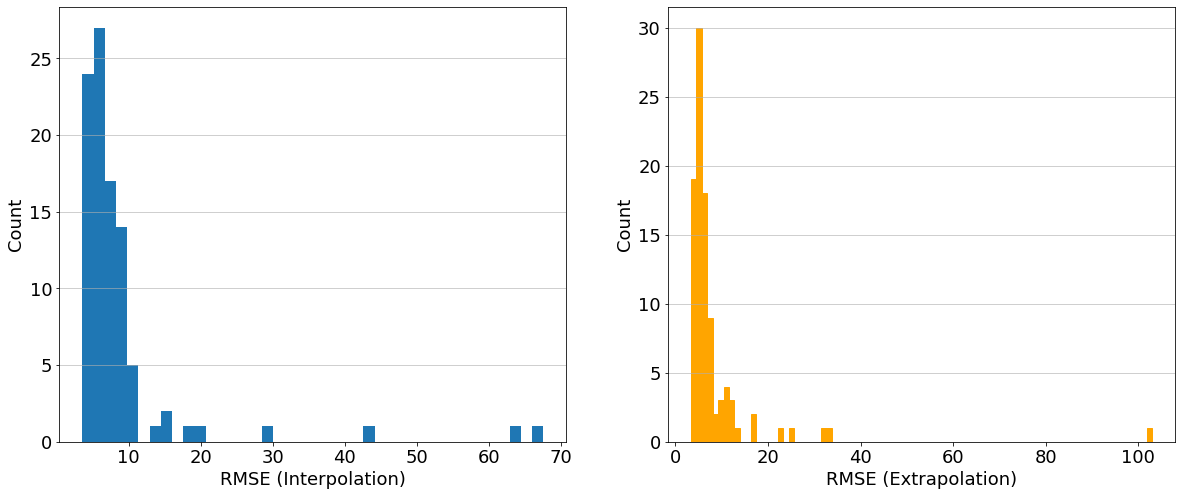

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plt.rcParams["font.size"] = '20'
ax1.grid(axis='y', alpha=0.75)
ax1.hist(RMSE_list2, bins='auto')
ax1.set(xlabel='RMSE (Interpolation)', ylabel='Count')
ax2.grid(axis='y', alpha=0.75)
ax2.hist(RMSE_list1, bins='auto', color = 'orange', ec='orange')
ax2.set(xlabel='RMSE (Extrapolation)', ylabel='Count')

plt.show()

# Experiment 3: Linear Function with Temporal Shared GP

## Create data

In [ ]:
# Generate data
n, m = 1000, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
n_datasets = 20
n_valid = 5
datasets, validation_datasets = generate_datasets(n, m, p, n_datasets, n_valid, func='linear_func', random_state=60)

In [ ]:
# Create groups
groups = np.arange(n)
for i in range(m):
    groups[i*p:(i+1)*p] = i

# Create times for validation datasets
times = np.tile(np.arange(p)*10+10, m)

## Hyperparameter tuning for GPBoost

### Random intercept

In [ ]:
# Random slope
gp_model = gpb.GPModel(group_data=groups)
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.1, 0.5], 
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=0,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

### Shared GP

In [ ]:
# Shared GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cov_function='exponential')
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Use the same hyperparameters as for Independent GP and only cross-validate to find num_boost_round
params = {'learning_rate': 0.1,
          'max_depth': 5,
          'min_data_in_leaf': 10,
          'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid={},
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

### Independent GP

In [ ]:
# Independent GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cluster_ids=groups, cov_function='exponential')
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.1, 0.5],
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

## Hyperparameter tuning for MERF

In [ ]:
accuracies = MERF_cv_multiple(validation_datasets, n_valid)

In [ ]:
print(np.argmax(accuracies))

0


## Comparison of different approaches

In [ ]:
# Create results dataframe
results_3 = pd.DataFrame(columns=["RMSE Interpolation (mean)", "RMSE Interpolation (std)", "RMSE Extrapolation (mean)", "RMSE Extrapolation (std)", "RMSE_F (mean)", "RMSE_F (std)", "Time"],
                         index=["Linear Mixed Effects Model with no fixed features (random intercept)",
                                "Linear Mixed Effects Model with Random Intercept",
                                "Linear Mixed Effects Model with Shared Gaussian Process",
                                "Linear Mixed Effects Model with Independent Gaussian Process",
                                "MERF",
                                "GPBoost with Random Intercept",
                                "GPBoost with Shared Gaussian Process",
                                "GPBoost with Independent Gaussian Process"])

In [ ]:
# 1. Linear Mixed Effects Model with no fixed features (random intercept)
time_list, RMSE_list1, RMSE_list2 = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False, no_features=True)

results_3.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "Time"] = np.mean(time_list)
results_3.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_3.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_3.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_3.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (std)"] = np.std(RMSE_list2)

In [ ]:
# 2. Linear Mixed Effects Model with Random Intercept
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False)

results_3.loc["Linear Mixed Effects Model with Random Intercept", "Time"] = np.mean(time_list)
results_3.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_3.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_3.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_3.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_3.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_3.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 3. Linear Mixed Effects Model with Shared Gaussian Process
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=True)

results_3.loc["Linear Mixed Effects Model with Shared Gaussian Process", "Time"] = np.mean(time_list)
results_3.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_3.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_3.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_3.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_3.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_3.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 4. Linear Mixed Effects Model with Independent Gaussian Process
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=False)

results_3.loc["Linear Mixed Effects Model with Independent Gaussian Process", "Time"] = np.mean(time_list)
results_3.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_3.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_3.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_3.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_3.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_3.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 5. MERF
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=True)

results_3.loc["MERF", "Time"] = np.mean(time_list)
results_3.loc["MERF", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_3.loc["MERF", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_3.loc["MERF", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_3.loc["MERF", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_3.loc["MERF", "RMSE_F (mean)"] = np.mean(F_list)
results_3.loc["MERF", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 6. GPBoost with Random Intercept
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 1,
          'min_data_in_leaf': 50,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=32, params=params, merf=False, linear=False, GP=False)
results_3.loc["GPBoost with Random Intercept", "Time"] = np.mean(time_list)
results_3.loc["GPBoost with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_3.loc["GPBoost with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_3.loc["GPBoost with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_3.loc["GPBoost with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_3.loc["GPBoost with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_3.loc["GPBoost with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 7. GPBoost with Shared Gaussian Process
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 1,
          'min_data_in_leaf': 50,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=36, params=params, merf=False, linear=False, GP=True, shared=True)
results_3.loc["GPBoost with Shared Gaussian Process", "Time"] = np.mean(time_list)
results_3.loc["GPBoost with Shared Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_3.loc["GPBoost with Shared Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_3.loc["GPBoost with Shared Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_3.loc["GPBoost with Shared Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_3.loc["GPBoost with Shared Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_3.loc["GPBoost with Shared Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 8. GPBoost with Independent Gaussian Process
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 1,
          'min_data_in_leaf': 50,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=29, params=params, merf=False, linear=False, GP=True, shared=False)
results_3.loc["GPBoost with Independent Gaussian Process", "Time"] = np.mean(time_list)
results_3.loc["GPBoost with Independent Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_3.loc["GPBoost with Independent Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_3.loc["GPBoost with Independent Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_3.loc["GPBoost with Independent Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_3.loc["GPBoost with Independent Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_3.loc["GPBoost with Independent Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
results_3

# Experiment 4: Linear Function with Temporal Independent GP

## Create data

In [ ]:
# Generate data
n, m = 1000, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
n_datasets = 20
n_valid = 5
datasets, validation_datasets = generate_datasets(n, m, p, n_datasets, n_valid, func='linear_func', shared_gp=False, random_state=40)

In [ ]:
# Create groups
groups = np.arange(n)
for i in range(m):
    groups[i*p:(i+1)*p] = i

# Create times for validation datasets
times = np.tile(np.arange(p)*10+10, m)

## Hyperparameter tuning for GPBoost

### Random intercept

In [ ]:
# Random slope
gp_model = gpb.GPModel(group_data=groups)
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.5, 1.0], 
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=0,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 18 parameter combinations...
Best number of iterations:  16.2
Best score:  7.129455849859751
Best parameters:  {'learning_rate': 0.5, 'max_depth': 5, 'min_data_in_leaf': 10}


### Shared GP

In [ ]:
# Shared GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cov_function='exponential')
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Other parameters not contained in the grid of tuning parameters
params = {'learning_rate': 0.5,
          'max_depth': 1,
          'min_data_in_leaf': 10,
          'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid={},
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 1 parameter combinations...
Trying parameter combination 1 of 1: {} ...
***** New best score (2.4527056638321016) found for the following parameter combination:
{'num_boost_round': 46.4}
Best number of iterations:  46.4
Best score:  2.4527056638321016
Best parameters:  {}


### Independent GP

In [ ]:
# Independent GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cluster_ids=groups, cov_function='exponential')
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent',
                                  'use_nesterov_acc': True})

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.1, 0.5],
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [1, 10, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 12 parameter combinations...
Trying parameter combination 1 of 12: {'learning_rate': 0.1, 'max_depth': 1, 'min_data_in_leaf': 10} ...
***** New best score (2.4550722795423363) found for the following parameter combination:
{'learning_rate': 0.1, 'max_depth': 1, 'min_data_in_leaf': 10, 'num_boost_round': 171.2}
Trying parameter combination 2 of 12: {'learning_rate': 0.5, 'max_depth': 1, 'min_data_in_leaf': 10} ...
***** New best score (2.4527981666302807) found for the following parameter combination:
{'learning_rate': 0.5, 'max_depth': 1, 'min_data_in_leaf': 10, 'num_boost_round': 46.8}
Trying parameter combination 3 of 12: {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 10} ...
Trying parameter combination 4 of 12: {'learning_rate': 0.5, 'max_depth': 5, 'min_data_in_leaf': 10} ...
Trying parameter combination 5 of 12: {'learning_rate': 0.1, 'max_depth': 10, 'min_data_in_leaf': 10} ...
Trying parameter combination 6 of 12: {'learning_r

## Hyperparameter tuning for MERF

In [ ]:
accuracies = MERF_cv_multiple(validation_datasets, n_valid)

In [ ]:
print(np.argmax(accuracies))

## Comparison of different approaches

In [ ]:
# Create results dataframe
results_4 = pd.DataFrame(columns=["RMSE Interpolation (mean)", "RMSE Interpolation (std)", "RMSE Extrapolation (mean)", "RMSE Extrapolation (std)", "RMSE_F (mean)", "RMSE_F (std)", "Time"],
                         index=["Linear Mixed Effects Model with no fixed features (random intercept)",
                                "Linear Mixed Effects Model with Random Intercept",
                                "Linear Mixed Effects Model with Shared Gaussian Process",
                                "Linear Mixed Effects Model with Independent Gaussian Process",
                                "MERF",
                                "GPBoost with Random Intercept",
                                "GPBoost with Shared Gaussian Process",
                                "GPBoost with Independent Gaussian Process"])

In [ ]:
# 1. Linear Mixed Effects Model with no fixed features (random intercept)
time_list, RMSE_list1, RMSE_list2 = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False, no_features=True)

results_4.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "Time"] = np.mean(time_list)
results_4.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_4.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_4.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_4.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (std)"] = np.std(RMSE_list2)

In [ ]:
# 2. Linear Mixed Effects Model with Random Intercept
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False)

results_4.loc["Linear Mixed Effects Model with Random Intercept", "Time"] = np.mean(time_list)
results_4.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_4.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_4.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_4.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_4.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_4.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 3. Linear Mixed Effects Model with Shared Gaussian Process
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=True)

results_4.loc["Linear Mixed Effects Model with Shared Gaussian Process", "Time"] = np.mean(time_list)
results_4.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_4.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_4.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_4.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_4.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_4.loc["Linear Mixed Effects Model with Shared Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 4. Linear Mixed Effects Model with Independent Gaussian Process
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=False)

results_4.loc["Linear Mixed Effects Model with Independent Gaussian Process", "Time"] = np.mean(time_list)
results_4.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_4.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_4.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_4.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_4.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_4.loc["Linear Mixed Effects Model with Independent Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 5. MERF
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=True)

results_4.loc["MERF", "Time"] = np.mean(time_list)
results_4.loc["MERF", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_4.loc["MERF", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_4.loc["MERF", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_4.loc["MERF", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_4.loc["MERF", "RMSE_F (mean)"] = np.mean(F_list)
results_4.loc["MERF", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 6. GPBoost with Random Intercept
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 5,
          'min_data_in_leaf': 10,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=17, params=params, merf=False, linear=False, GP=False)
results_4.loc["GPBoost with Random Intercept", "Time"] = np.mean(time_list)
results_4.loc["GPBoost with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_4.loc["GPBoost with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_4.loc["GPBoost with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_4.loc["GPBoost with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_4.loc["GPBoost with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_4.loc["GPBoost with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 7. GPBoost with Shared Gaussian Process
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 5,
          'min_data_in_leaf': 10,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=19, params=params, merf=False, linear=False, GP=True, shared=True)
results_4.loc["GPBoost with Shared Gaussian Process", "Time"] = np.mean(time_list)
results_4.loc["GPBoost with Shared Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_4.loc["GPBoost with Shared Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_4.loc["GPBoost with Shared Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_4.loc["GPBoost with Shared Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_4.loc["GPBoost with Shared Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_4.loc["GPBoost with Shared Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
# 8. GPBoost with Independent Gaussian Process
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 5,
          'min_data_in_leaf': 10,
          'verbose': 0}
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=19, params=params, merf=False, linear=False, GP=True, shared=False)
results_4.loc["GPBoost with Independent Gaussian Process", "Time"] = np.mean(time_list)
results_4.loc["GPBoost with Independent Gaussian Process", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_4.loc["GPBoost with Independent Gaussian Process", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_4.loc["GPBoost with Independent Gaussian Process", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_4.loc["GPBoost with Independent Gaussian Process", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_4.loc["GPBoost with Independent Gaussian Process", "RMSE_F (mean)"] = np.mean(F_list)
results_4.loc["GPBoost with Independent Gaussian Process", "RMSE_F (std)"] = np.std(F_list)

In [ ]:
results_4

,RMSE Interpolation (mean),RMSE Interpolation (std),RMSE Extrapolation (mean),RMSE Extrapolation (std),RMSE_F (mean),RMSE_F (std),Time
Linear Mixed Effects Model with no fixed features (random intercept),7.23842,4.03478,5.92631,1.95776,NaN,NaN,0.000478005
Linear Mixed Effects Model with Random Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear Mixed Effects Model with Shared Gaussian Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear Mixed Effects Model with Independent Gaussian Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MERF,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPBoost with Random Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPBoost with Shared Gaussian Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPBoost with Independent Gaussian Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN
